1. 删掉 ST
2. 删掉业绩亏损
3. 删掉净资产为负
4. 选取市盈率前 200 名
5. 选取市净率 200 名
6. MA-5 > MA - 21 且缺口变大 || MA-21 > MA-5 且缺口变小

In [1]:
import tushare as ts
import numpy as np
import datetime


## Set up the date
today = '20' + datetime.date.today().strftime('%y%m%d')

In [2]:
index_all = ts.get_today_all()

df1 = index_all.copy()  #建立一个备份
n = 100  #选择前n个数据

[Getting data:]############################################################

In [3]:
#df1.head(2)

,code,name,changepercent,trade,open,high,low,settlement,volume,turnoverratio,amount,per,pb,mktcap,nmc
0,688399,硕世生物,-2.813,80.50,83.99,83.99,77.45,82.83,1701786.0,12.75848,135717507.0,55.517,9.465,471891.0,107374.68350
1,688398,赛特新材,1.095,59.11,58.00,59.22,56.50,58.47,1411040.0,7.75248,81541154.0,82.097,11.444,472880.0,107586.93854


In [4]:
df1['a']=[('ST' in x )for x in df1.name.astype(str)]  #先给ST股票做标记a
df1=df1.set_index('a')  #将a设置为索引 
df1=df1.drop(index=[True]) #删除ST股票
df1=df1.reset_index(drop=True) #重建默认索引

In [7]:
#删除业绩亏损的股票
df1=df1[df1.per >0]

#删除净资产为负的股票
df1=df1[df1.pb >0]

#选取市盈率前 200 名股票
df2=df1.sort_values(by=['per'],ascending=True).head(n)
#print(len(df2))
#选取市净率 200 名股票
df3=df1.sort_values(by=['pb'],ascending=True).head(n)
#print(len(df3))
#生成股票代码集合，进行集合运算
g2=set(df2.code) #低市盈率股票代码
#print(len(g2))
g3=set(df3.code) #低市净率股票代码
#print(len(g3))
g=g2&g3 #集合交运算
#print(len(g))
zxg1=list(g)  #把集合转为列表
print('Basic Selection:',zxg1, "Totally:", len(zxg1))

Basic Selection: ['601328', '600000', '601988', '000040', '600971', '600708', '600016', '600022', '600376', '000402', '601166', '601169', '601288', '000825', '000900', '000898', '601998', '000959', '601818', '600657', '600569', '601077', '000980', '600348', '000791', '000926', '600823', '600919', '600019', '600015', '002092', '600782', '600997', '600123', '000732'] Totally: 35


In [8]:
# Comparing MA-5 & MA-21
# MA-5 ts.get_hist_data(zxg1[i])['close'].rolling(5).mean().shift(-4) 
# MA-21 ts.get_hist_data(zxg1[i])['close'].rolling(21).mean().shift(-20) 

# If MA-5 > MA-21, it is bullrish
# If MA-5 < MA-21, it is bearish

MA_5L_21 = []
def MA(name, date):
    return ts.get_hist_data(name)['close'].rolling(date).mean().shift(-date + 1)

from tqdm import tqdm

stock_wanted = []
for i in tqdm(range(0, len(zxg1))):
    MA5_21 = (MA(zxg1[i],5) - MA(zxg1[i], 21)).to_frame()[0:5] 
    MA21_5 = (MA(zxg1[i],21) - MA(zxg1[i], 5)).to_frame()[0:5] 
    # if (dataframe['close'][3] == True) and (dataframe['close'][4] == True):
    if (MA5_21['close'][0] > MA5_21['close'][1]) and (MA5_21['close'][1] > MA5_21['close'][2]) and (MA5_21['close'][2] > MA5_21['close'][3]):
        print("This stock maybe a good choice", zxg1[i])
        MA_5L_21.append(zxg1[i])
    if (MA21_5['close'][0] > MA21_5['close'][1]) and (MA21_5['close'][1] > MA21_5['close'][2]) and (MA21_5['close'][2] > MA21_5['close'][3]):
        print("This stock maybe a good choice", zxg1[i])
        MA_5L_21.append(zxg1[i])
print(MA_5L_21)


 11%|█▏        | 4/35 [00:04<00:31,  1.03s/it]

This stock maybe a good choice 000040



 20%|██        | 7/35 [00:07<00:28,  1.02s/it]

This stock maybe a good choice 600016



 26%|██▌       | 9/35 [00:09<00:26,  1.03s/it]

This stock maybe a good choice 600376



 57%|█████▋    | 20/35 [00:20<00:15,  1.04s/it]

This stock maybe a good choice 600657



 74%|███████▍  | 26/35 [00:26<00:08,  1.00it/s]

This stock maybe a good choice 000926



 89%|████████▊ | 31/35 [00:31<00:04,  1.03s/it]

This stock maybe a good choice 002092



100%|██████████| 35/35 [00:35<00:00,  1.02s/it]

This stock maybe a good choice 000732
['000040', '600016', '600376', '600657', '000926', '002092', '000732']


### HMM Prediction

In [9]:
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from docopt import docopt
import tushare as ts
import os

class StockPredictor(object):
    def __init__(self, company, test_size=0.8,
                 n_hidden_states=2, n_latency_days=2,
                 n_steps_frac_change=10, n_steps_frac_high=10,
                 n_steps_frac_low=10):
        self._init_logger()
 
        self.company = company
        if type(company) == str:
            compnay = company
        if type(company) == int:
            company = str(company)
        
        self.data = ts.get_hist_data(str(company)).reset_index()
        
        self.n_latency_days = n_latency_days
        self.hmm = GaussianHMM(n_components=n_hidden_states)
        self._split_train_test_data(company, test_size)
 
        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)
 
    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
 
    def _split_train_test_data(self,company, test_size):
        data = ts.get_hist_data(company).reset_index()
        test_data, _train_data = train_test_split(
            data, test_size=test_size, shuffle=False)
 
        self._train_data = _train_data
        self._test_data = test_data
 
    @staticmethod
    def _extract_features(data):
        open_price = np.array(data['open'])
        close_price = np.array(data['close'])
        high_price = np.array(data['high'])
        low_price = np.array(data['low'])
 
        # 计算收盘价、高价和低价的分数变化
        # 这会用到一个特征
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price
 
        return np.column_stack((frac_change, frac_high, frac_low))
 
    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vector = StockPredictor._extract_features(self._train_data)
        self._logger.info('Features extraction Completed <<<')
 
        self.hmm.fit(feature_vector)
 
    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
 
        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range, frac_high_range, frac_low_range)))
 
    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_end_index: previous_data_start_index]
        previous_data_features = StockPredictor._extract_features(
            previous_data)
 
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
 
        return most_probable_outcome
 
    def predict_close_price(self, day_index):
        open_price = self._test_data.iloc[day_index]['open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(
            day_index)
        return open_price * (1 + predicted_frac_change)
 
    def predict_close_prices_for_days(self, days, with_plot=False):
        predicted_close_prices = []
        for day_index in tqdm(range(days)):
            predicted_close_prices.append(self.predict_close_price(day_index))
 
        if with_plot:
            test_data = self._test_data[0: days]
            days = np.array(test_data['date'], dtype="datetime64[ms]")
            actual_close_prices = test_data['close']
 
            fig = plt.figure()
 
            axes = fig.add_subplot(111)
            axes.plot(days, actual_close_prices, 'bo-', label="actual")
            axes.plot(days, predicted_close_prices, 'r+-', label="predicted")
            axes.set_title('{company}'.format(company=self.company)+"HMM Prediciton")
 
            fig.autofmt_xdate()
 
            plt.legend()
            if os.getcwd == '/Users/terencelau/Documents/Documents - Terence的MacBook Pro/Development/stock_selection/img':
                print("CWD is right")
            if os.getcwd != '/Users/terencelau/Documents/Documents - Terence的MacBook Pro/Development/stock_selection/img':
                os.chdir('/Users/terencelau/Documents/Documents - Terence的MacBook Pro/Development/stock_selection/img')
            plt.savefig('{company}'.format(company=self.company)+".png")
            plt.show()
 
        return predicted_close_prices

#stock_predictor = StockPredictor(601988)
#stock_predictor.fit()
#stock_predictor.predict_close_prices_for_days(10, with_plot=True)




  0%|          | 0/7 [00:00<?, ?it/s]2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:23,337 __main__     INFO     >>> 

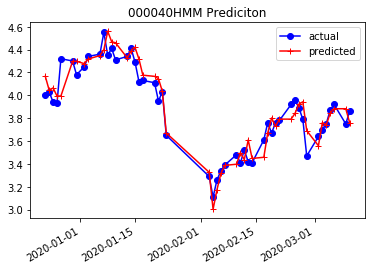




 14%|█▍        | 1/7 [00:21<02:11, 21.89s/it]2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO     >>> Extracting Features
2020-03-10 17:03:45,293 __main__     INFO 

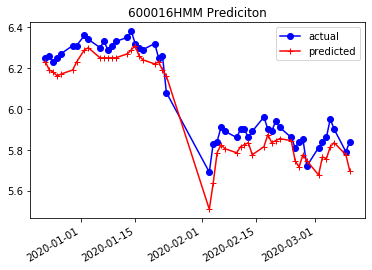




 29%|██▊       | 2/7 [00:44<01:50, 22.17s/it]2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:08,078 __main__     INFO 

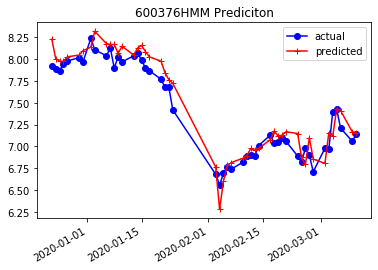




 43%|████▎     | 3/7 [01:07<01:29, 22.37s/it]2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:30,891 __main__     INFO 

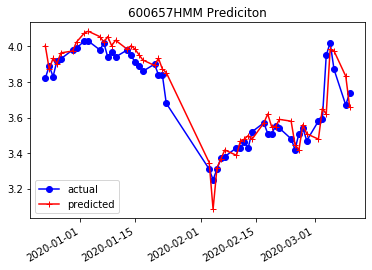




 57%|█████▋    | 4/7 [01:30<01:07, 22.41s/it]2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO     >>> Extracting Features
2020-03-10 17:04:53,401 __main__     INFO 

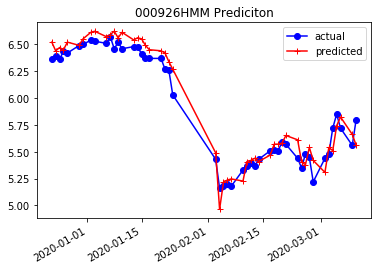




 71%|███████▏  | 5/7 [01:52<00:44, 22.28s/it]2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:15,367 __main__     INFO 

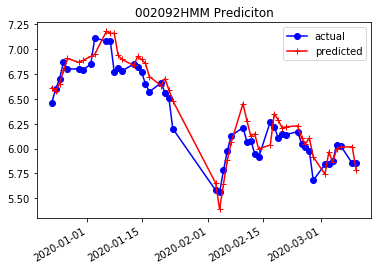




 86%|████████▌ | 6/7 [02:13<00:22, 22.12s/it]2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO     >>> Extracting Features
2020-03-10 17:05:37,089 __main__     INFO 

In [ ]:
for tmp in tqdm(range(0, len(MA_5L_21))):
    stock_predictor = StockPredictor(MA_5L_21[tmp])
    stock_predictor.fit()
    stock_predictor.predict_close_prices_for_days(50, with_plot=True)